## Supermarket store branches sales analysis
https://www.kaggle.com/datasets/surajjha101/stores-area-and-sales-data

Projeto com fins de estudo de modelos de Regressão Linear

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [303]:
df = pd.read_csv('Stores.csv')

In [304]:
df.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [305]:
# There're only numeric variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 896 entries, 0 to 895
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store ID              896 non-null    int64
 1   Store_Area            896 non-null    int64
 2   Items_Available       896 non-null    int64
 3   Daily_Customer_Count  896 non-null    int64
 4   Store_Sales           896 non-null    int64
dtypes: int64(5)
memory usage: 35.1 KB


In [306]:
# There is no NaN
df.isna().sum()

Store ID                0
Store_Area              0
Items_Available         0
Daily_Customer_Count    0
Store_Sales             0
dtype: int64

In [307]:
df.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [308]:
# There's one branch that only has 10 daily customers. This value seems is to be too low in comparison with the mean,
# so it might be an outlier
df.Daily_Customer_Count.nsmallest(5)

39      10
151     70
876    100
230    120
146    130
Name: Daily_Customer_Count, dtype: int64

In [309]:
# Getting the z-score of that value. 
# It'll be considered an outlier if the zscore is greater than |3|
stats.zscore(df.Daily_Customer_Count)[39]

-2.926960872097397

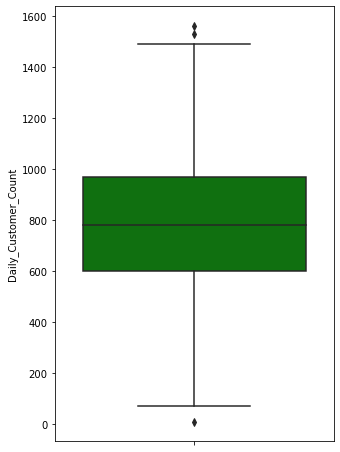

In [310]:
# Checking wheter the 10 daily consumers is really too low or an accetable value.
# It's not very far from the last percentile, so I'll keep it.
plt.figure(figsize=(5,8))
sns.boxplot(data = df , y = 'Daily_Customer_Count', color = 'green');

In [311]:
# Visualizing the other columns in the line where the daily costumer is 10 to check if they seem ok, only to confirm.
# All the other lines show regular values.
df.loc[39]


Store ID                   40
Store_Area               1270
Items_Available          1516
Daily_Customer_Count       10
Store_Sales             45480
Name: 39, dtype: int64

In [312]:
# There is no duplicated values.
df.duplicated().sum()

0

In [313]:
df.columns

Index(['Store ID ', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [314]:
# Taking the black space out of the first column name ('Store ID').
df.columns = df.columns.str.replace(df.columns[0], df.columns[0][:-1])

In [315]:
df.columns

Index(['Store ID', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

In [316]:
# Setting Store ID as index
df.set_index(['Store ID'])

,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
Store ID,,,,
1,1659,1961,530,66490
2,1461,1752,210,39820
3,1340,1609,720,54010
4,1451,1748,620,53730
5,1770,2111,450,46620
...,...,...,...,...
892,1582,1910,1080,66390
893,1387,1663,850,82080
894,1200,1436,1060,76440


# Variable Analysis:
- Compare the variables with the target variable 'Store_Sales'


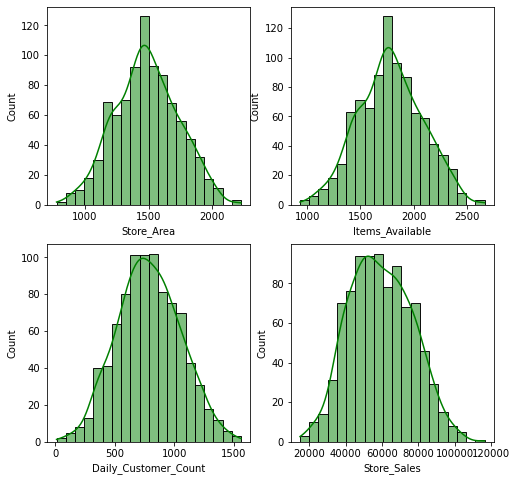

In [317]:
# Plotting a histogram to all the variables of the dataset
# They alll have a Gaussian Distribution
plt.figure(figsize = (8,8))

for i in range(1, len(df.columns)):
    plt.subplot(2, 2, i)
    sns.histplot(data = df, x = df.columns[i], bins = 20, color = 'green', kde = True)

In [318]:
# Variables Correlation
corr_df = df[df.columns].corr()

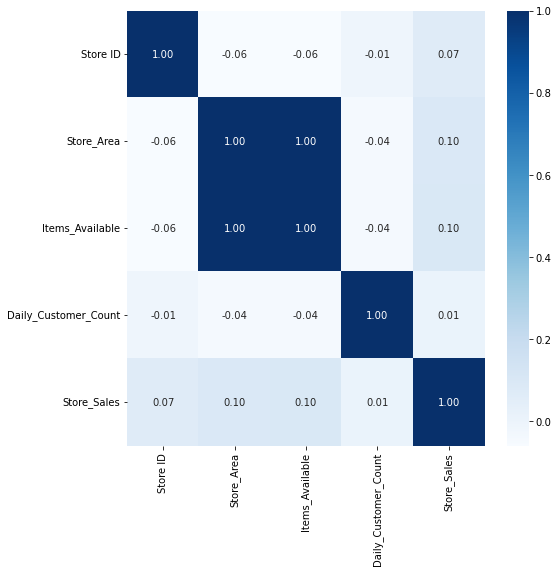

In [319]:
# Heatmap
# It's possible to see that Store_Area and Item_avaliable is totally positive related(1.0). 
# Even tough it's suspicious to have such a positive relation, it makes sense, since the more itens a supermarket has,
# the more area is needed
# The others variables are not much related.
plt.figure(figsize=(8,8))

sns.heatmap(data = corr_df, cmap = 'Blues', annot = True, fmt = '.2f')

*Decision*: We might take a decision here to only apply Feature Engineering in variables which the correlation is >=  0.10
('Daily_Customer_Count' won't be used to train the algorithm)

In [320]:
df.columns

Index(['Store ID', 'Store_Area', 'Items_Available', 'Daily_Customer_Count',
       'Store_Sales'],
      dtype='object')

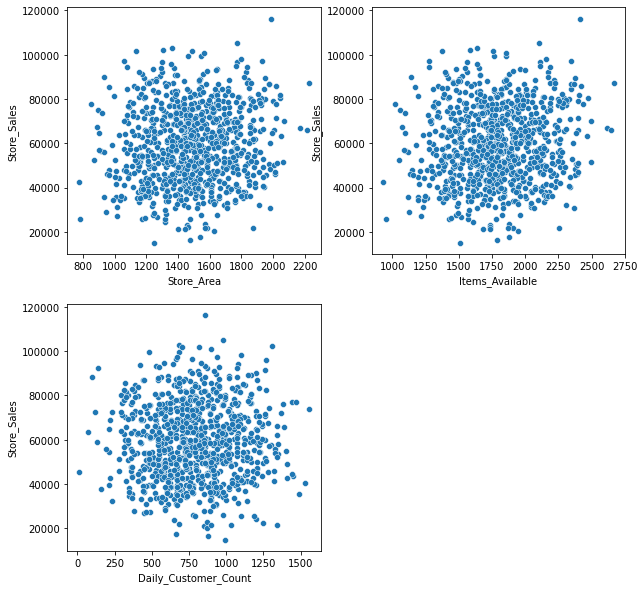

In [321]:
# Comparing the variables with the the Store Sales using a scatterplot
plt.figure(figsize=(10,10))

for i in range(1, len(df.columns)-1):
    plt.subplot(2,2, i)
    sns.scatterplot(data = df, x = df.columns[i], y = 'Store_Sales');

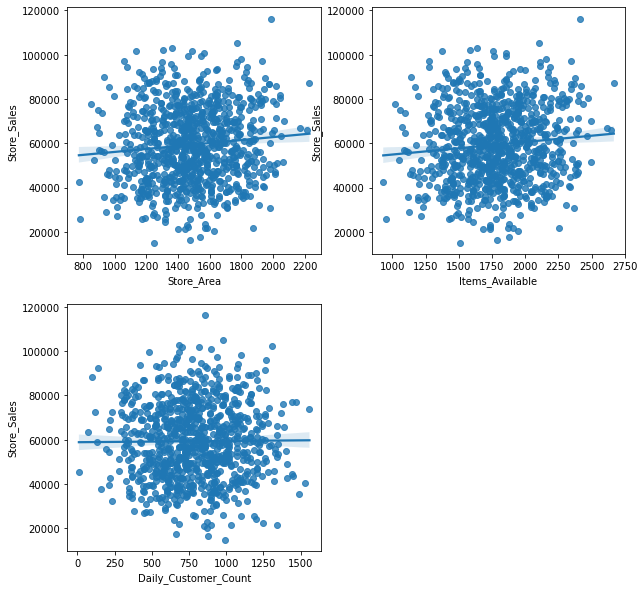

In [322]:
# Regression plot
# It's able to see more clearly the relation between the variables and the Store Sales
plt.figure(figsize=(10,10))

for i in range(1,len(df.columns)-1):
    plt.subplot(2,2,i)
    sns.regplot(data = df, x = df.columns[i], y='Store_Sales')

> Conclusion: The 'Store_Area' and 'Items_Available' area have a slight positive relation with the target variable 'Store_Sales'

**Feature Engineering**

I'm going to create separate the variable 'Store_Area' and 'Items_Available' into bins and put into new variables for different analysis


In [323]:
df_eng = df.copy()

In [324]:
df_eng.head()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
0,1,1659,1961,530,66490
1,2,1461,1752,210,39820
2,3,1340,1609,720,54010
3,4,1451,1748,620,53730
4,5,1770,2111,450,46620


In [325]:
df_eng.describe()

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales
count,896.000000,896.000000,896.000000,896.000000,896.000000
mean,448.500000,1485.409598,1782.035714,786.350446,59351.305804
std,258.797218,250.237011,299.872053,265.389281,17190.741895
min,1.000000,775.000000,932.000000,10.000000,14920.000000
25%,224.750000,1316.750000,1575.500000,600.000000,46530.000000
50%,448.500000,1477.000000,1773.500000,780.000000,58605.000000
75%,672.250000,1653.500000,1982.750000,970.000000,71872.500000
max,896.000000,2229.000000,2667.000000,1560.000000,116320.000000


In [326]:
# The variable 'Store_Area' and 'Items_Available' will be put in bins
bin1 = [0, 1250, 1750, 2250]
label_bin1 = ['<1250m²', '1250-1749m²', '1750-2250m²']
bin2 = [0, 1300, 1800, 2300, 2800]
label_bin2 = ['<1300','1300-1799','1800-2299', '2300-2800']

In [327]:
df_eng['Store_Area_bins'] = pd.cut(df_eng['Store_Area'],
                                    bins = bin1,
                                    labels=label_bin1,
                                    )

In [328]:
df_eng.Store_Area_bins.value_counts()

1250-1749m²    572
<1250m²        178
1750-2250m²    146
Name: Store_Area_bins, dtype: int64

In [329]:
df_eng.sample(10)

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Store_Area_bins
376,377,1496,1774,810,75490,1250-1749m²
832,833,1330,1606,590,38510,1250-1749m²
301,302,1585,1916,1110,50740,1250-1749m²
179,180,1626,1941,1350,58090,1250-1749m²
885,886,1118,1337,560,72270,<1250m²
263,264,1875,2254,1120,70400,1750-2250m²
830,831,1724,2101,900,66390,1250-1749m²
144,145,1498,1770,620,59380,1250-1749m²
711,712,1360,1612,490,61080,1250-1749m²
511,512,1247,1490,330,65750,<1250m²


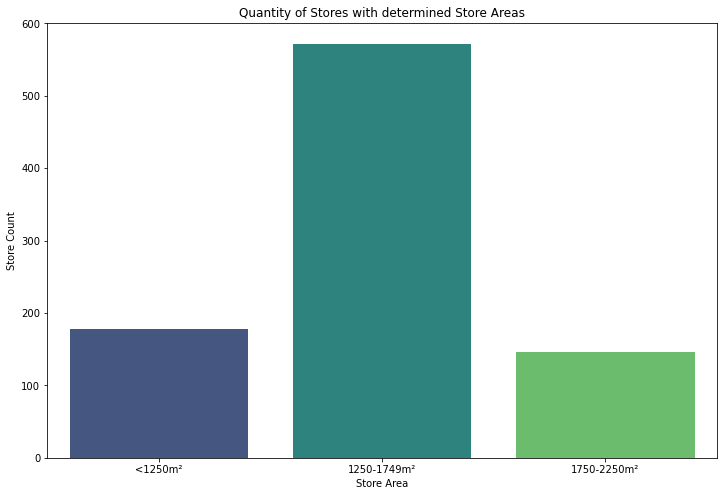

In [330]:
plt.figure(figsize =(12,8))
sns.countplot(x = df_eng['Store_Area_bins'], orient = 'v', palette = 'viridis')
plt.title('Quantity of Stores with determined Store Areas')
plt.xlabel('Store Area')
plt.ylabel('Store Count')
plt.show()

In [331]:
df_eng['Items_Available_bins'] = pd.cut(df_eng['Items_Available'],
                                                bins = bin2,
                                                labels = label_bin2)

In [332]:
df_eng.Items_Available_bins.value_counts()

1300-1799    437
1800-2299    372
<1300         47
2300-2800     40
Name: Items_Available_bins, dtype: int64

In [333]:
df_eng.sample(8)

,Store ID,Store_Area,Items_Available,Daily_Customer_Count,Store_Sales,Store_Area_bins,Items_Available_bins
416,417,1440,1733,1120,65310,1250-1749m²,1300-1799
181,182,1174,1396,1100,40930,<1250m²,1300-1799
386,387,1415,1697,1200,39420,1250-1749m²,1300-1799
67,68,1416,1681,290,72710,1250-1749m²,1300-1799
453,454,1808,2154,990,35220,1750-2250m²,1800-2299
86,87,1931,2342,940,97260,1750-2250m²,2300-2800
787,788,1427,1723,1040,67090,1250-1749m²,1300-1799
668,669,1068,1278,440,64120,<1250m²,<1300


In [334]:
# They've become categorical
new_columns = ['Items_Available_bins', 'Store_Area_bins']

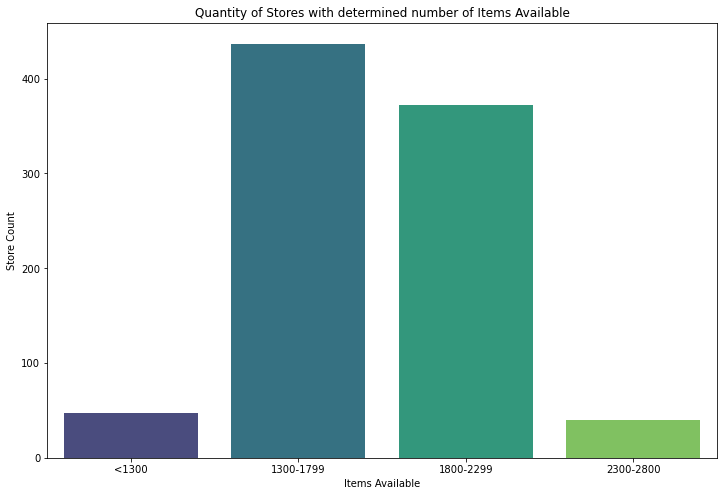

In [335]:
plt.figure(figsize =(12,8))
sns.countplot(x = df_eng['Items_Available_bins'], orient = 'v', palette = 'viridis')
plt.title('Quantity of Stores with determined number of Items Available')
plt.xlabel('Items Available')
plt.ylabel('Store Count')
plt.show()

Most of the stores have between 1300 to 2299 Items Available

### Visualizing the Store sales by the Store Area

In [336]:
df_report1 = df_eng.groupby(['Store_Area_bins']).agg({'Store_Sales':['mean']}).reset_index()
df_report1

,Store_Area_bins,Store_Sales
,,mean
0,<1250m²,56983.820225
1,1250-1749m²,59247.657343
2,1750-2250m²,62643.767123


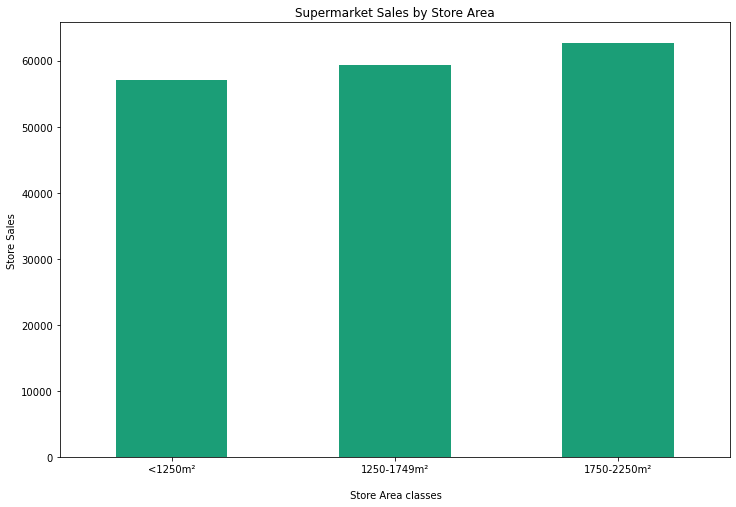

In [337]:
df_report1.set_index('Store_Area_bins').plot(kind = 'bar',
                                             title = 'Supermarket Sales by Store Area',
                                             xlabel = '\n Store Area classes',
                                             ylabel = 'Store Sales',
                                             figsize = (12,8),
                                             colormap = 'Dark2',
                                             legend = '')
plt.xticks(rotation = 0)
plt.show()

>Conclusion: It's possible to saythat the Store Area has a slight positive relation in the Store Sales 

### Visualizing the Store Sales by the Items Available

In [338]:
df_report2 = df_eng.groupby(['Items_Available_bins']).agg({'Store_Sales':['mean']}).reset_index()
df_report2

,Items_Available_bins,Store_Sales
,,mean
0,<1300,54998.936170
1,1300-1799,58641.556064
2,1800-2299,59944.784946
3,2300-2800,66700.000000


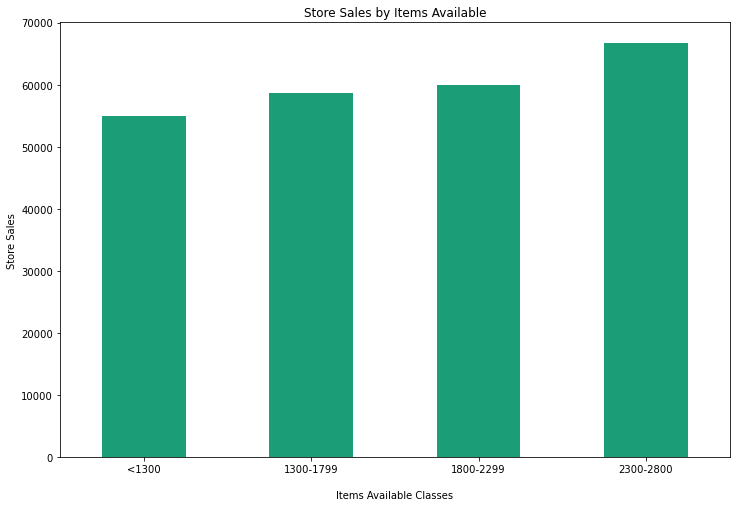

In [339]:
df_report2.set_index('Items_Available_bins').plot(kind = 'bar',
                                                  title = 'Store Sales by Items Available',
                                                  xlabel = '\nItems Available Classes',
                                                  ylabel = 'Store Sales',
                                                  figsize = (12,8),
                                                  colormap = 'Dark2',
                                                  legend = '')
plt.xticks(rotation = 0)
plt.show()

>Conclusion: It's possible to say that the 'Items Available' has a slight positive relation in the Store Sales 

**Comparing the quantity of itens available with the Store Area**

### Visualizing the Store Area by Items Available

In [340]:
df_report3 = df_eng.groupby(['Items_Available_bins']).agg({'Store_Area':['mean']}).reset_index()
df_report3

,Items_Available_bins,Store_Area
,,mean
0,<1300,989.148936
1,1300-1799,1334.324943
2,1800-2299,1670.741935
3,2300-2800,1995.525000


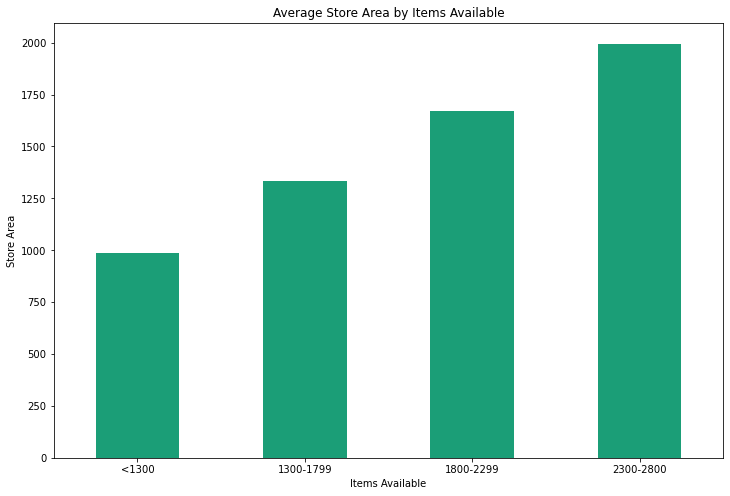

In [341]:
df_report3.set_index('Items_Available_bins').plot(kind = 'bar',
                                                  title = 'Average Store Area by Items Available',
                                                  xlabel = 'Items Available',
                                                  ylabel = 'Store Area',
                                                  colormap = 'Dark2',
                                                  figsize = (12,8),
                                                  legend = '')
plt.xticks(rotation = 0)
plt.show()

> Conclusion: Store Area has a positive correlation with Items Available

### Comparing the Store Area with the number of Daily Customer

In [342]:
df_report4 = df_eng.groupby(['Store_Area_bins']).agg({'Daily_Customer_Count':'mean'}).reset_index()
df_report4

,Store_Area_bins,Daily_Customer_Count
0,<1250m²,816.292135
1,1250-1749m²,776.520979
2,1750-2250m²,788.356164


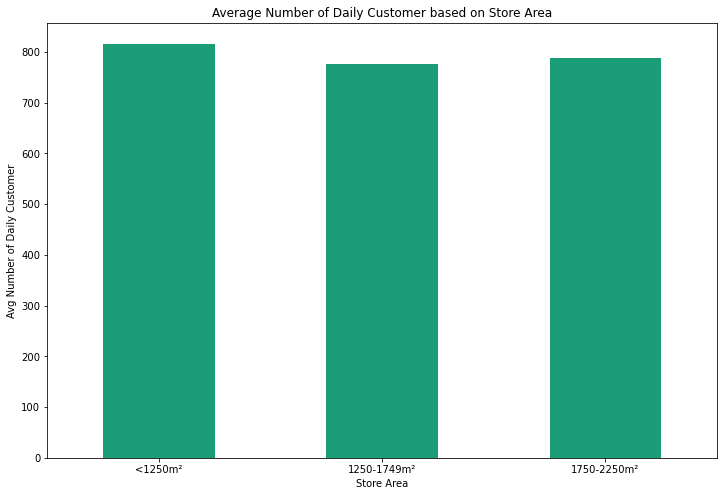

In [343]:
df_report4.set_index('Store_Area_bins').plot(kind = 'bar',
                                             title = 'Average Number of Daily Customer based on Store Area',
                                             xlabel = 'Store Area',
                                             ylabel = 'Avg Number of Daily Customer',
                                             figsize = (12,8),
                                             colormap = 'Dark2',
                                             legend = '')
plt.xticks(rotation = 0)
plt.show()

*Conclusion:* The Store area doesn't seem to have relation with the number of Daily Customer